# Code to Solve the Image Deblurring Problem

## Problem formulation

$\boldsymbol{y} = \boldsymbol{S} \left( \boldsymbol{b} \circledast \boldsymbol{x} + \boldsymbol{\varepsilon} \right) = \boldsymbol{S} \left( \mathcal{C} (\boldsymbol{b})\boldsymbol{x} + \boldsymbol{\varepsilon} \right), \hspace{2ex} \boldsymbol{\varepsilon} \sim \mathcal{N} (0, \sigma^2 \boldsymbol{I}), \hspace{2ex} \sigma \geq 0.$

- $\boldsymbol{x} \in \mathbb{R}^{n}$: (vectorized) unknown image to recover 
- $\boldsymbol{b} \in \mathbb{R}^{n}$: (vectorized) blurring kernel
- $\mathcal{C}(\boldsymbol{b})$ : circulant matrix of $\boldsymbol{b}$
- $\boldsymbol{\varepsilon} \in \mathbb{R}^{m}$: noise
- $ \sigma \in \mathbb{R}^+$: noise level 
- $ \boldsymbol{y} \in \mathbb{R}^{n}$: observed measurements
- $ \circledast : \mathbb{R}^{n} \times \mathbb{R}^{n} \mapsto \mathbb{R}^{n}$: denotes cicular convolution (https://en.wikipedia.org/wiki/Convolution)
- $ \boldsymbol{S} \in \mathbb{R}^{m} \times \mathbb{R}^{n}$: subsampling matrix

## Loss function, gradients

### Loss function:

$\ell ({\boldsymbol{x}}) = \frac{1}{2m} \| \boldsymbol{y} - \boldsymbol{S} \mathcal{C} (\boldsymbol{b})\boldsymbol{x} \|_2^2$

### Loss function as a finite sum:

$\ell (\boldsymbol{x}) := \frac{1}{m} \sum_i^m \ell_{i}(\boldsymbol{x}) = \frac{1}{m}\sum_i^m \frac{1}{2}(y_i - \mathcal{C}_i(\boldsymbol{b}) \boldsymbol{x})^2$

- $\mathcal{C}_i(\boldsymbol{b})$ denotes the $i^{\text{th}}$ row of the circulant matrix of $\boldsymbol{b}$

### Full gradient:

$\nabla \ell ({\boldsymbol{x}}) = \frac{1}{m} \boldsymbol{S}^\top \mathcal{C} (\boldsymbol{b})^\top ( \boldsymbol{S} \mathcal{C} (\boldsymbol{b}) \boldsymbol{x} - \boldsymbol{y} ) $

### Stochastic gradient:

$\nabla \ell_{i}({\boldsymbol{x}}) = \boldsymbol{S}^\top_i \mathcal{C} (\boldsymbol{b})^\top_i (\boldsymbol{x}^\top \mathcal{C}_i(\boldsymbol{b}) - y_i ) $



In [1]:
%matplotlib inline 

from imports import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# No Subsampling --> Perfect Recovery?

(128, 128)


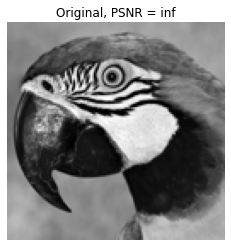

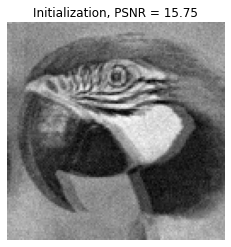

In [21]:
height = 128
width = 128
subsample_rate = 1

problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./deblurring/kernel.png', H=height, W=width, sigma=0.1, subsampling=subsample_rate)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
print(noisy.shape)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

(-0.5, 127.5, 127.5, -0.5)

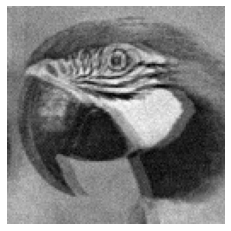

In [22]:
measurements = problem.y.reshape(height//subsample_rate,width//subsample_rate)
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [32]:
denoiser = NLMDenoiser(filter_decay=0.99,
                       filter_size=0.01, patch_size=5, patch_distance=12, multichannel=True)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_svrg(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=.05, tt=10, T2=1, 
                                                   mini_batch_size=problem.num_meas, verbose=True)

After gradient update: 0 0 17.882010631499178
After denoising update: 0 0 17.885761809352264

After gradient update: 1 0 19.51459682721787
After denoising update: 1 0 19.520511225077524

After gradient update: 2 0 20.73781004516521
After denoising update: 2 0 20.743987195753327

After gradient update: 3 0 21.650894707611485
After denoising update: 3 0 21.656169795485695

After gradient update: 4 0 22.337712076323477
After denoising update: 4 0 22.341575790692275

After gradient update: 5 0 22.859865968095406
After denoising update: 5 0 22.862459885237328

After gradient update: 6 0 23.260322309940452
After denoising update: 6 0 23.26198417902281

After gradient update: 7 0 23.56871165733473
After denoising update: 7 0 23.569824617411115

After gradient update: 8 0 23.805875934872347
After denoising update: 8 0 23.80664277102997

After gradient update: 9 0 23.98677602929043
After denoising update: 9 0 23.98734308139161

After gradient update: 10 0 24.122575224341865
After denoising upda

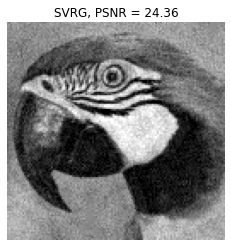

In [33]:
psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=128, W=128)

# Subsample rate of 2

(128, 128)


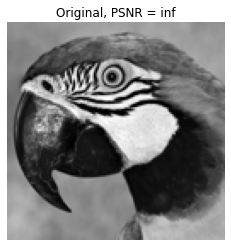

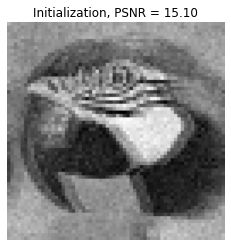

In [35]:
height = 128
width = 128
subsample_rate = 2

problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./deblurring/kernel.png', H=height, W=width, sigma=0.1, subsampling=subsample_rate)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
print(noisy.shape)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

(-0.5, 63.5, 63.5, -0.5)

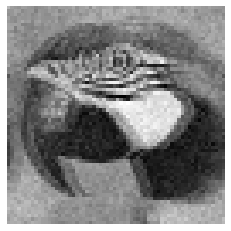

In [36]:
measurements = problem.y.reshape(height//subsample_rate,width//subsample_rate)
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [37]:
denoiser = NLMDenoiser(filter_decay=0.99,
                       filter_size=0.01, patch_size=5, patch_distance=12, multichannel=True)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_svrg(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=.05, tt=10, T2=1, 
                                                   mini_batch_size=problem.num_meas, verbose=True)

After gradient update: 0 0 16.772032284425592
After denoising update: 0 0 16.780371836026898

After gradient update: 1 0 17.926164452163015
After denoising update: 1 0 17.936486836695376

After gradient update: 2 0 18.695375587326552
After denoising update: 2 0 18.70625047735252

After gradient update: 3 0 19.20307099729029
After denoising update: 3 0 19.213508171623292

After gradient update: 4 0 19.538640711248927
After denoising update: 4 0 19.548356644258547

After gradient update: 5 0 19.76126612178145
After denoising update: 5 0 19.770028424560703

After gradient update: 6 0 19.90877131528769
After denoising update: 6 0 19.916399418726584

After gradient update: 7 0 20.005520701471184
After denoising update: 7 0 20.012000236548996

After gradient update: 8 0 20.06751822103204
After denoising update: 8 0 20.072943584548618

After gradient update: 9 0 20.1054109830009
After denoising update: 9 0 20.109990002197794

After gradient update: 10 0 20.126422623145817
After denoising upda

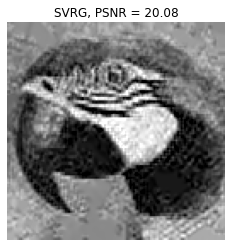

In [38]:
psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=128, W=128)

# Subsample rate of 4

(128, 128)


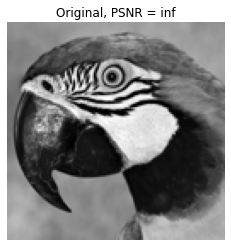

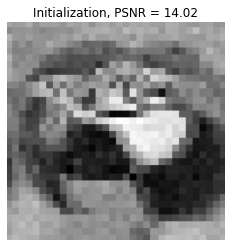

In [39]:
height = 128
width = 128
subsample_rate = 4

problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./deblurring/kernel.png', H=height, W=width, sigma=0.1, subsampling=subsample_rate)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
print(noisy.shape)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

(-0.5, 31.5, 31.5, -0.5)

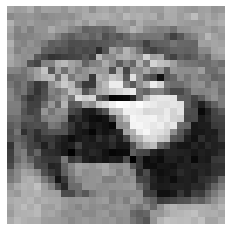

In [40]:
measurements = problem.y.reshape(height//subsample_rate,width//subsample_rate)
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [58]:
denoiser = NLMDenoiser(filter_decay=0.99,
                       filter_size=0.01, patch_size=5, patch_distance=12, multichannel=True)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_svrg(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=.001, tt=100, T2=10, 
                                                   mini_batch_size=problem.num_meas//10, verbose=True)

After gradient update: 0 0 14.038895781961182
After denoising update: 0 0 14.045687966145548

After gradient update: 0 1 14.06981289985438
After denoising update: 0 1 14.075166459422539

After gradient update: 0 2 14.098512180565104
After denoising update: 0 2 14.102446669270481

After gradient update: 0 3 14.124498260615315
After denoising update: 0 3 14.127233232743494

After gradient update: 0 4 14.149126963932773
After denoising update: 0 4 14.150946930775037

After gradient update: 0 5 14.174309102760256
After denoising update: 0 5 14.175244011546708

After gradient update: 0 6 14.198625322199172
After denoising update: 0 6 14.199215178106726

After gradient update: 0 7 14.219827130643594
After denoising update: 0 7 14.220326419700198

After gradient update: 0 8 14.242921981915028
After denoising update: 0 8 14.243209324356483

After gradient update: 0 9 14.265118725192611
After denoising update: 0 9 14.26531922505834

After gradient update: 1 0 14.28698910849228
After denoising u

After gradient update: 8 8 15.305616380076062
After denoising update: 8 8 15.30557677018895

After gradient update: 8 9 15.31215165239151
After denoising update: 8 9 15.312135510323907

After gradient update: 9 0 15.31895369036395
After denoising update: 9 0 15.318922418343119

After gradient update: 9 1 15.325568348689513
After denoising update: 9 1 15.325548570308086

After gradient update: 9 2 15.331529961559307
After denoising update: 9 2 15.331510495640927

After gradient update: 9 3 15.33727127279416
After denoising update: 9 3 15.33724522855412

After gradient update: 9 4 15.342731593852202
After denoising update: 9 4 15.34270646523196

After gradient update: 9 5 15.348194801692456
After denoising update: 9 5 15.348164698554465

After gradient update: 9 6 15.353303476199686
After denoising update: 9 6 15.353276746796778

After gradient update: 9 7 15.358386985054304
After denoising update: 9 7 15.358345801642066

After gradient update: 9 8 15.362923283275187
After denoising upda

After gradient update: 17 4 15.441713852768338
After denoising update: 17 4 15.441681867139266

After gradient update: 17 5 15.440107855654938
After denoising update: 17 5 15.440085601397481

After gradient update: 17 6 15.438393601108713
After denoising update: 17 6 15.438365356927005

After gradient update: 17 7 15.436818230927571
After denoising update: 17 7 15.436788787671444

After gradient update: 17 8 15.434552473628129
After denoising update: 17 8 15.434529190867142

After gradient update: 17 9 15.433059227611514
After denoising update: 17 9 15.433035718261333

After gradient update: 18 0 15.43086426061061
After denoising update: 18 0 15.43083908622366

After gradient update: 18 1 15.428426910288746
After denoising update: 18 1 15.428400478767134

After gradient update: 18 2 15.42691665750797
After denoising update: 18 2 15.426902475552254

After gradient update: 18 3 15.424728384637383
After denoising update: 18 3 15.424709814403638

After gradient update: 18 4 15.422203654292

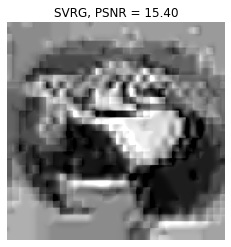

In [59]:
psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=128, W=128)